In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install bs4

     |████████████████████████████████| 115 kB 1.2 MB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=95b2e10a599b3dd02e7ee930037f82c89b222cb86780e946584070976302da7a
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [3]:
import re

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup


from wordcloud import WordCloud 

import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')

In [5]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


This train dataset consists of the following features:
- **Id:** a numerical identifier for the tweet. This will be important when we upload our predictions to the leaderboard.
- **Keyword:** a keyword from the tweet which may in some cases be missing.
- **Location:** the location the tweet was sent from. This may also not be present.
- **Text:** the full text of the tweet.
- **Target:** this is the label we are trying to predict. This will be 1 if the tweet is really about a disaster and 0 if not.

In [7]:
#total data length
print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in test'.format(test_df.shape[0],test_df.shape[1]))

# unique location and keyword size of data
print("Checking train location column values",len(train_df.location.unique()))
print("Checking train keyword column values",len(train_df.keyword.unique()))
print("Checking test location column values",len(test_df.location.unique()))
print("Checking test keyword column values",len(test_df.keyword.unique()))

#number of disaster tweets
print("disaster tweets", len(train_df[train_df["target"]==1]) )
print("non-disaster tweets", len(train_df[train_df["target"]==0]) )

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test
Checking train location column values 3342
Checking train keyword column values 222
Checking test location column values 1603
Checking test keyword column values 222
disaster tweets 3271
non-disaster tweets 4342


Now I plot the target value distribution

Not Disaster: 57.03%, Disaster: 42.97%


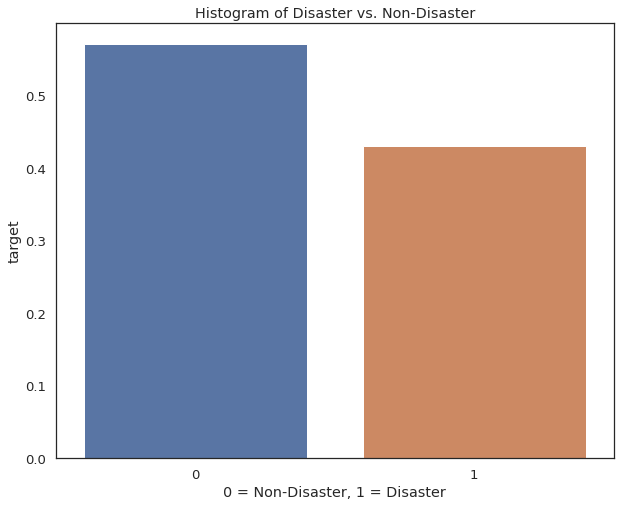

In [8]:
target_distribution = train_df["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_distribution[0], target_distribution[1]))

sns.barplot(x=target_distribution.index, y=target_distribution)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

As you can see there are more data points with the label 0 meaning tweets that are not disaster tweets and fewer data points with the label 1 which is tweets that are related to a disaster. Usually, for data that has some skewed labels, it is recommended to use an F-score instead of accuracy for model evaluation.

In [9]:
#take look at neutral tweets
train_df[train_df.target == 0].head(2)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0


In [10]:
#take look at disaster tweets
train_df[train_df.target == 1].head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


Now we can take a look at the distribution of `Keywords` and `Locations`. We plot 20 most repeated values for each.

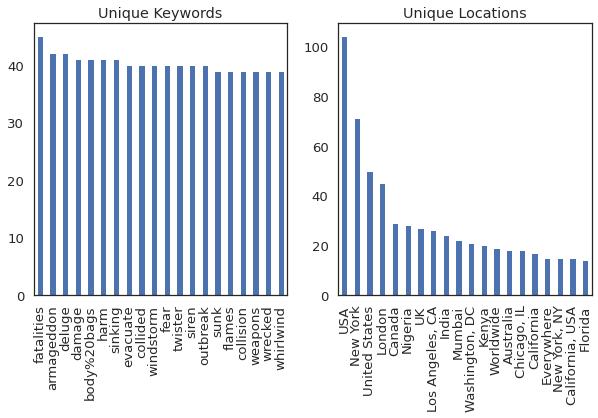

In [11]:
plt.subplots(1,2,figsize=(10,5))
#visualize top 20 train unique keywords
plt.subplot(1,2,1)
train_df.keyword.value_counts()[:20].plot(kind="bar",title="Unique Keywords")

#visualize top 20 train unique locations
plt.subplot(1,2,2)
train_df.location.value_counts()[:20].plot(kind="bar",title="Unique Locations")

plt.show()

We can also plot Keywords and Location for different categories.

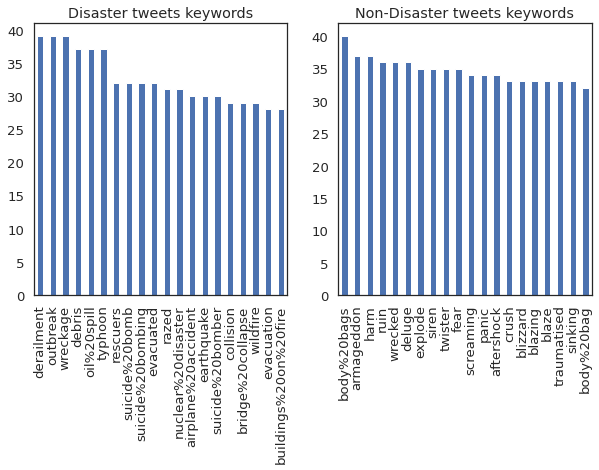

In [12]:
plt.subplots(1,2,figsize=(10,5))
#visualize top 20 disaster tweets and their keywords bar graph
plt.subplot(1,2,1)
train_df[train_df["target"]==1].keyword.value_counts()[:20].plot(kind="bar",title="Disaster tweets keywords")

#visualize top 20 non disaster tweets and their keywords bar graph
plt.subplot(1,2,2)
train_df[train_df["target"]==0].keyword.value_counts()[:20].plot(kind="bar",title="Non-Disaster tweets keywords")

plt.show()

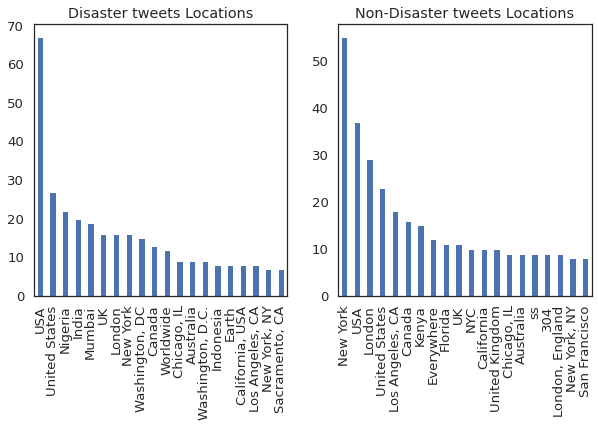

In [13]:
plt.subplots(1,2,figsize=(10,5))
#visualize top 20 disaster tweets and their locations bar graph
plt.subplot(1,2,1)
train_df[train_df["target"]==1].location.value_counts()[:20].plot(kind="bar",title="Disaster tweets Locations")

#visualize top 20 non disaster tweets and their locations bar graph
plt.subplot(1,2,2)
train_df[train_df["target"]==0].location.value_counts()[:20].plot(kind="bar",title="Non-Disaster tweets Locations")

plt.show()

#### Taking care of null values

In [14]:
null_counts = pd.DataFrame({"Number_Null": train_df.isnull().sum()})
null_counts["Percent_Null"] = null_counts["Number_Null"] / train_df.count() * 100
null_counts

,Number_Null,Percent_Null
id,0,0.000000
keyword,61,0.807733
location,2533,49.862205
text,0,0.000000
target,0,0.000000


Location includes `2533` null values and `61` values for keywords are null in train dataset.

In [15]:
null_counts = pd.DataFrame({"Number_Null": test_df.isnull().sum()})
null_counts["Percent_Null"] = null_counts["Number_Null"] / test_df.count() * 100
null_counts

,Number_Null,Percent_Null
id,0,0.000000
keyword,26,0.803213
location,1105,51.204819
text,0,0.000000


Location includes `1105` null values and`26` keywords are null in test dataset.

We can delete the values for these two columns as they seem not neccessary

In [16]:
# Let's get rid of `Location` and  `keywords` columns as they are unnecessary.
# train_df.drop(['keyword','location'],axis=1,inplace=True)
# test_df.drop(['keyword','location'],axis=1,inplace=True)

Now we can examine if the neutral and disaster tweets, spread equally in our dataset

In [17]:
#take look at neutral tweets index distribution
train_df[train_df.target == 0].index

Int64Index([  15,   16,   17,   18,   19,   20,   21,   22,   23,   24,
            ...
            7576, 7577, 7578, 7579, 7580, 7581, 7582, 7584, 7587, 7593],
           dtype='int64', length=4342)

In [18]:
#take look at disaster tweets index distribution
train_df[train_df.target == 1].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612],
           dtype='int64', length=3271)

#### Taking care of duplicate values.

In [19]:
dupli_sum = train_df.text.duplicated().sum()

if(dupli_sum>0):
    print(dupli_sum, " duplicates found\nremoving duplicates...")
    train_df = train_df.loc[False==train_df.text.duplicated(), :]
    print('There are {} rows and {} columns in train after removing duplicates'
          .format(train_df.shape[0],train_df.shape[1]))
else:
    print("no duplicates found")
    
train_df

110  duplicates found
removing duplicates...
There are 7503 rows and 5 columns in train after removing duplicates


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


#### Extracting hashtags from tweets

In [20]:
#extract hashtags
train_df["hashtags"]=train_df["text"].apply(lambda x:re.findall(r"#(\w+)",x.lower()))
test_df["hashtags"]=test_df["text"].apply(lambda x:re.findall(r"#(\w+)",x.lower()))

#convert tokens hashtags to text
train_df["hashtags"]=train_df["hashtags"].apply(lambda x: ' '.join(x))
test_df["hashtags"]=test_df["hashtags"].apply(lambda x: ' '.join(x))

In [21]:
train_df.head(2)

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,


In [22]:
test_df.head(2)

,id,keyword,location,text,hashtags
0,0,NaN,NaN,Just happened a terrible car crash,
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake


## Exploratory Data Analysis

Adding length of the tweets before cleaning to the dataframe.

In [23]:
# add the characters length of tweets
train_df['text_len'] = [len(t) for t in train_df.text]
train_df.head(2)

,id,keyword,location,text,target,hashtags,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,38


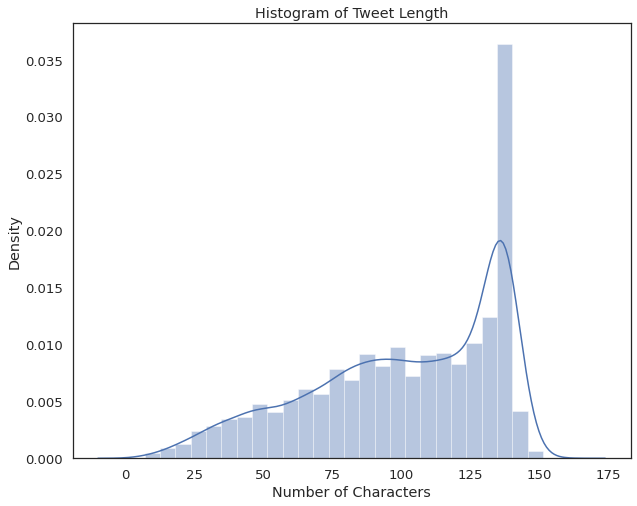

In [24]:
sns.distplot(train_df["text_len"])
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

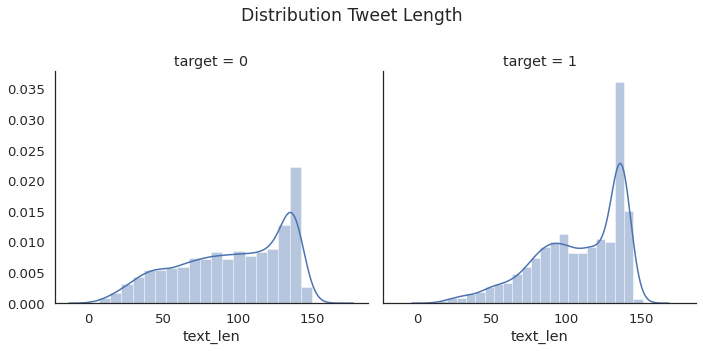

In [25]:
g = sns.FacetGrid(train_df, col="target", height=5)

g = g.map(sns.distplot, "text_len")
g.fig.subplots_adjust(top=.8)

plt.suptitle("Distribution Tweet Length")
plt.show()

It can be seen in above plot that the character distribution is left skewed.
what about the test dataset?

In [26]:
test_df['text_len'] = [len(t) for t in test_df.text]
test_df.head(2)

,id,keyword,location,text,hashtags,text_len
0,0,NaN,NaN,Just happened a terrible car crash,,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,64


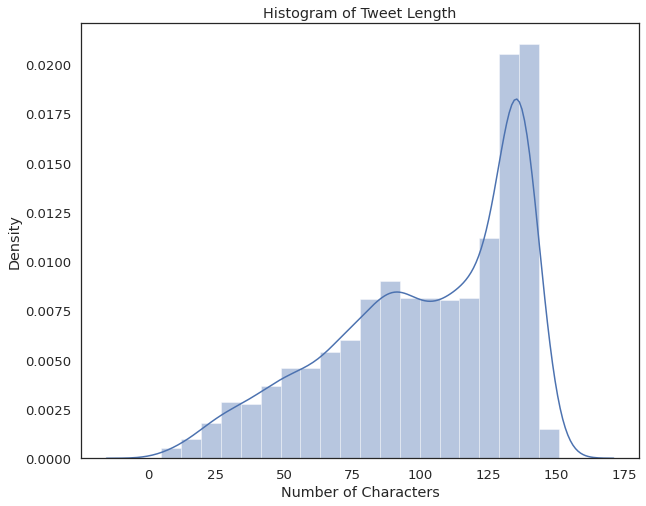

In [27]:
sns.distplot(test_df["text_len"])

plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

The test data set is also left skewed.

In [28]:
def count_words(x):
    '''
        A function to count number of words in a tweet
        inpit : tweet
        output: (int) number of words
    '''
    return len(x.split())

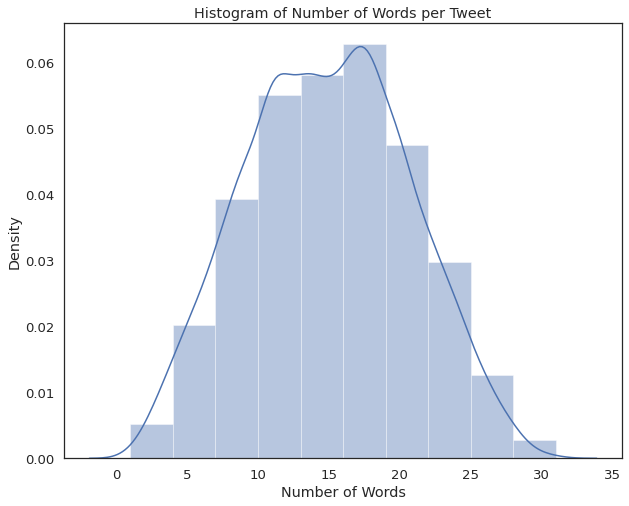

In [29]:
train_df["num_words_text"] = train_df["text"].apply(count_words)

sns.distplot(train_df["num_words_text"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

It seems that number of words follow a normal distribution.As we can see the majority of tweets are between 11 to 19 words.

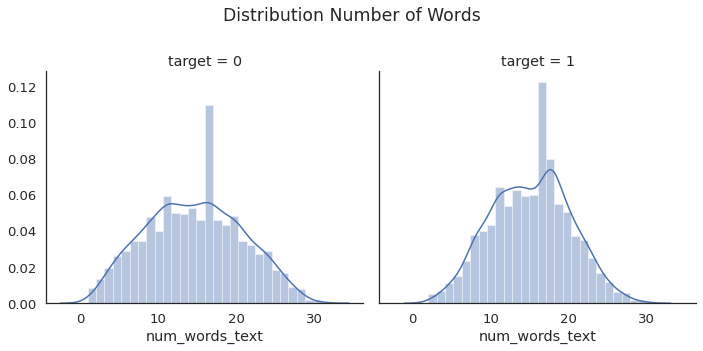

In [30]:
g = sns.FacetGrid(train_df, col="target", height=5)

g = g.map(sns.distplot, "num_words_text")
g.fig.subplots_adjust(top=.8)

plt.suptitle("Distribution Number of Words")
plt.show()

We do the same for test dataset.

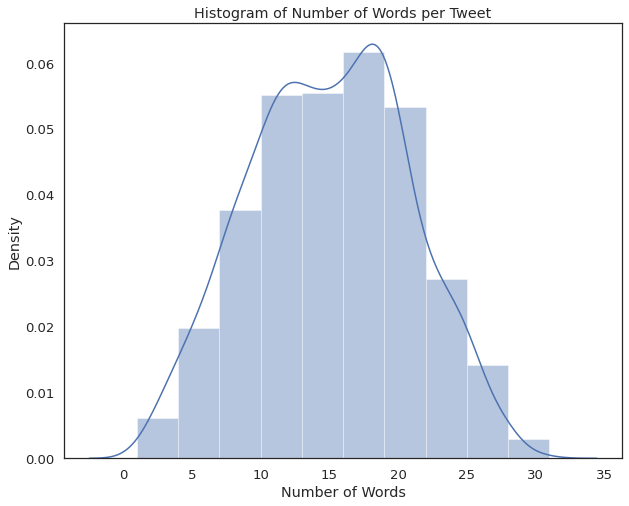

In [31]:
test_df["num_words_text"] = test_df["text"].apply(count_words)

sns.distplot(test_df["num_words_text"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

I do some further analysis on number of words and the length of the tweet by calculating the average word length of the tweets

In [32]:
def avg_word_length(x):
    return np.sum([len(w) for w in x.split()]) / len(x.split())

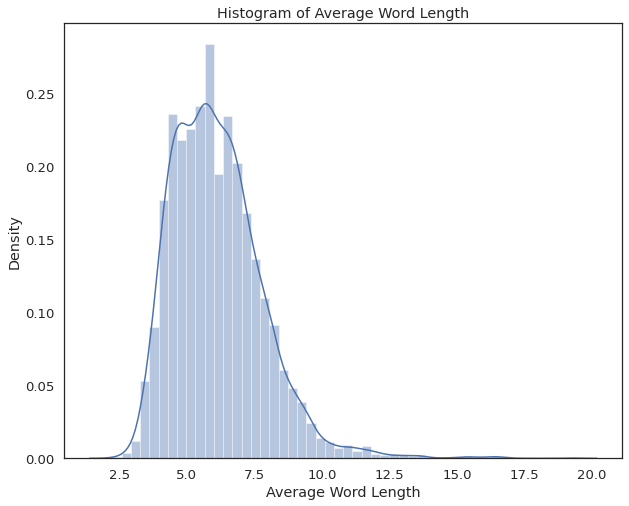

In [33]:
train_df["avg_word_length"] = train_df["text"].apply(avg_word_length)

sns.distplot(train_df["avg_word_length"])
plt.title("Histogram of Average Word Length")
plt.xlabel("Average Word Length")
plt.ylabel("Density")
plt.show()

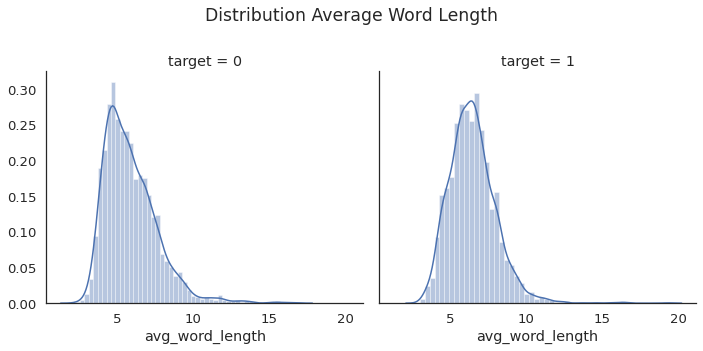

In [34]:
g = sns.FacetGrid(train_df, col="target", height=5)
g = g.map(sns.distplot, "avg_word_length")

g.fig.subplots_adjust(top=.8)

plt.suptitle("Distribution Average Word Length")
plt.show()

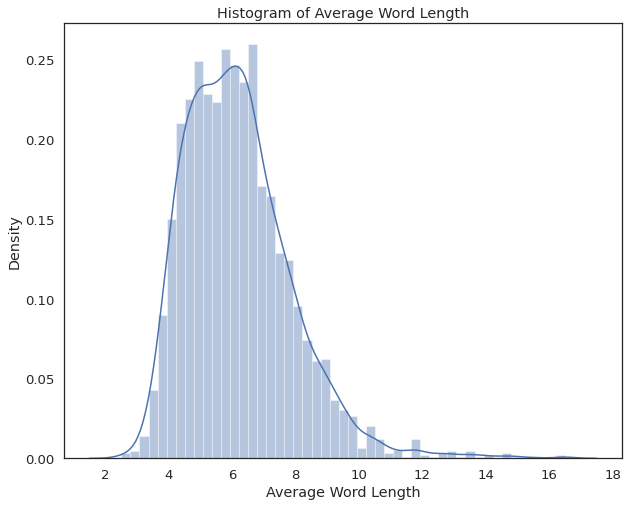

In [35]:
test_df["avg_word_length"] = test_df["text"].apply(avg_word_length)

sns.distplot(test_df["avg_word_length"])
plt.title("Histogram of Average Word Length")
plt.xlabel("Average Word Length")
plt.ylabel("Density")
plt.show()

## Preprocessing

In [36]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not", "haven't":"have not","hasn't":"has not",
                 "hadn't":"had not","won't":"will not","wouldn't":"would not","don't":"do not", "doesn't":"does not","didn't":"did not",
                 "can't":"can not","couldn't":"could not","shouldn't":"should not", "mightn't":"might not", "mustn't":"must not",
                 }

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
        
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)   
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    
    return (" ".join(words)).strip()

The order of the cleaning is
1. Souping
2. BOM removing
3. Url address(‘http:’pattern), twitter ID removing
4. Url address(‘www.'pattern) removing
5. Lower-case
6. Negation handling
7. Removing numbers and special characters
8. Tokenizing and joining

In [37]:
train_df['clean_text'] = train_df['text'].map(lambda x: tweet_cleaner(x))
test_df['clean_text'] = test_df['text'].map(lambda x: tweet_cleaner(x))

In [38]:
train_df.head(2)

,id,keyword,location,text,target,hashtags,text_len,num_words_text,avg_word_length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,69,13,4.384615,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,38,7,4.571429,forest fire near la ronge sask canada


In [39]:
test_df.head(2)

,id,keyword,location,text,hashtags,text_len,num_words_text,avg_word_length,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,,34,6,4.833333,just happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,64,9,6.222222,heard about earthquake is different cities sta...


In [40]:
# Length of tweets after cleaning
train_df['clean_text_len'] = [len(t) for t in train_df.clean_text]
train_df.head(2)

,id,keyword,location,text,target,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,69,13,4.384615,our deeds are the reason of this earthquake ma...,68
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,38,7,4.571429,forest fire near la ronge sask canada,37


In [41]:
# Length of tweets after cleaning
test_df['clean_text_len'] = [len(t) for t in test_df.clean_text]
test_df.head(2)

,id,keyword,location,text,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len
0,0,NaN,NaN,Just happened a terrible car crash,,34,6,4.833333,just happened terrible car crash,32
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,64,9,6.222222,heard about earthquake is different cities sta...,61


In [42]:
# numbet of words in tweets after cleaning
train_df["clean_num_words"] = train_df["clean_text"].apply(count_words)
train_df.head(2)

,id,keyword,location,text,target,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,69,13,4.384615,our deeds are the reason of this earthquake ma...,68,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,38,7,4.571429,forest fire near la ronge sask canada,37,7


In [43]:
# numbet of words in tweets after cleaning
test_df["clean_num_words"] = test_df["clean_text"].apply(count_words)
test_df.head(2)

,id,keyword,location,text,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words
0,0,NaN,NaN,Just happened a terrible car crash,,34,6,4.833333,just happened terrible car crash,32,5
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,64,9,6.222222,heard about earthquake is different cities sta...,61,9


In [44]:
# Average words length in tweets after cleaning
train_df["clean_avg_word_length"] = train_df["clean_text"].apply(avg_word_length)
train_df.head(2)

,id,keyword,location,text,target,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words,clean_avg_word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,69,13,4.384615,our deeds are the reason of this earthquake ma...,68,13,4.307692
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,38,7,4.571429,forest fire near la ronge sask canada,37,7,4.428571


In [45]:
# Average words length in tweets after cleaning
test_df["clean_avg_word_length"] = test_df["clean_text"].apply(avg_word_length)
test_df.head(2)

,id,keyword,location,text,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words,clean_avg_word_length
0,0,NaN,NaN,Just happened a terrible car crash,,34,6,4.833333,just happened terrible car crash,32,5,5.600000
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,64,9,6.222222,heard about earthquake is different cities sta...,61,9,5.888889


Taking care of Stopwords

In [46]:
train_df['clean_text_stopword'] = train_df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
train_df.head(2)

,id,keyword,location,text,target,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words,clean_avg_word_length,clean_text_stopword
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,69,13,4.384615,our deeds are the reason of this earthquake ma...,68,13,4.307692,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,38,7,4.571429,forest fire near la ronge sask canada,37,7,4.428571,forest fire near la ronge sask canada


In [47]:
test_df['clean_text_stopword'] = test_df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
test_df.head(2)

,id,keyword,location,text,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words,clean_avg_word_length,clean_text_stopword
0,0,NaN,NaN,Just happened a terrible car crash,,34,6,4.833333,just happened terrible car crash,32,5,5.600000,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,64,9,6.222222,heard about earthquake is different cities sta...,61,9,5.888889,heard earthquake different cities stay safe ev...


In [48]:
#Dropping words whose length is less than 3
train_df['clean_text_stopword'] = train_df['clean_text_stopword'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
train_df.head(2)

,id,keyword,location,text,target,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words,clean_avg_word_length,clean_text_stopword
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,69,13,4.384615,our deeds are the reason of this earthquake ma...,68,13,4.307692,deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,38,7,4.571429,forest fire near la ronge sask canada,37,7,4.428571,forest fire near ronge sask canada


In [49]:
test_df['clean_text_stopword'] = test_df['clean_text_stopword'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
test_df.head(2)

,id,keyword,location,text,hashtags,text_len,num_words_text,avg_word_length,clean_text,clean_text_len,clean_num_words,clean_avg_word_length,clean_text_stopword
0,0,NaN,NaN,Just happened a terrible car crash,,34,6,4.833333,just happened terrible car crash,32,5,5.600000,happened terrible crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,64,9,6.222222,heard about earthquake is different cities sta...,61,9,5.888889,heard earthquake different cities stay safe ev...


## Word Cloud
A word cloud represents word usage in a document by resizing individual words proportionally to its frequency and then presenting them in a random arrangement. 

#### Plot Disaster tweets wordcloud

In [50]:
disaster_tweets = train_df[train_df.target == 1]
disaster_string = []

for t in disaster_tweets.clean_text_stopword:
    disaster_string.append(t)
    
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')

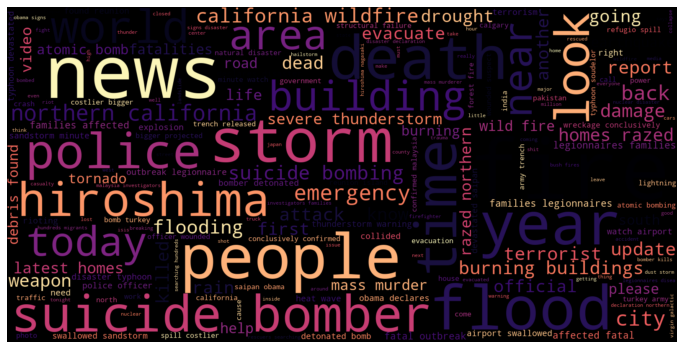

In [51]:
wordcloud_disaster = WordCloud(width=1600, height=800,max_font_size=200 ,colormap='magma').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_disaster, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Plot Neutral tweets wordcloud

In [52]:
neutral_tweets = train_df[train_df.target == 0]
neutral_string = []
for t in neutral_tweets.clean_text_stopword:
    neutral_string.append(t)
neutral_string = pd.Series(neutral_string).str.cat(sep=' ')

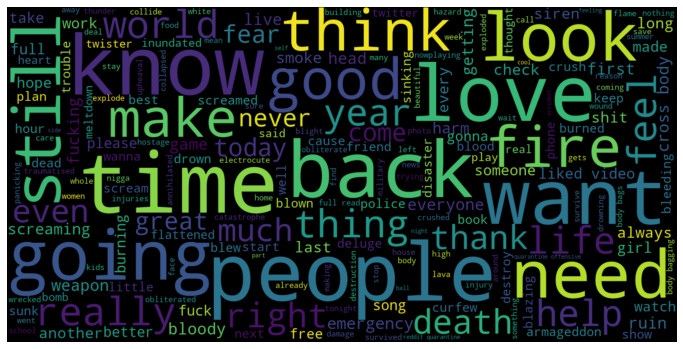

In [53]:
wordcloud_neutral = WordCloud(width=1600, height=800,max_font_size=200).generate(neutral_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.show()

### Visualize Bigram frequency distribution of tweets

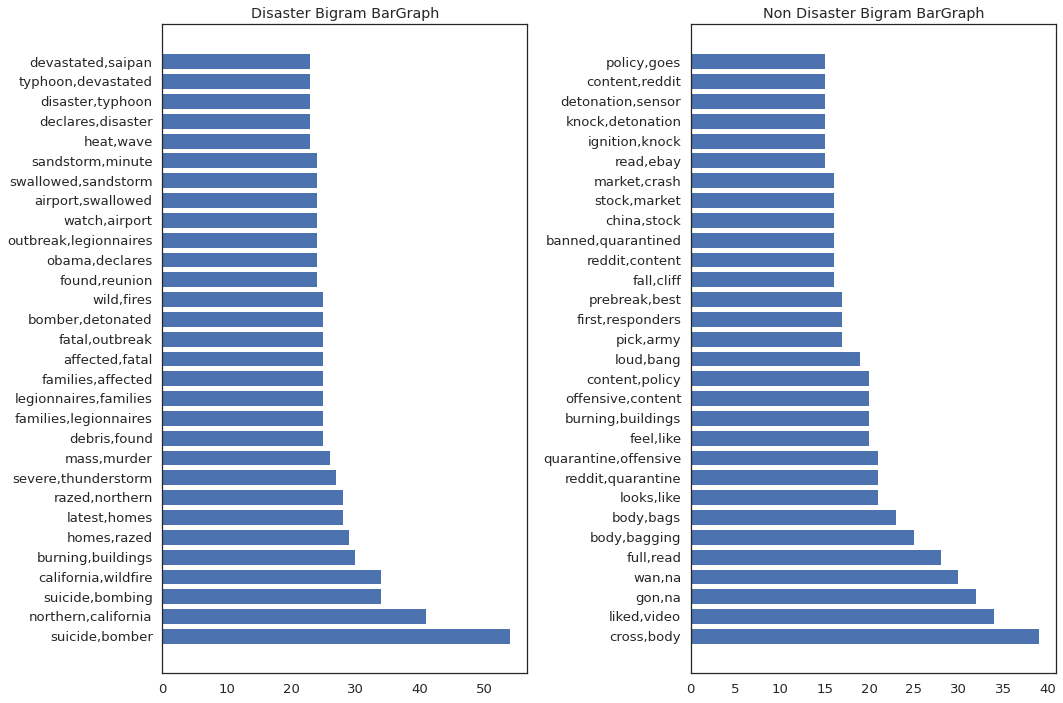

In [54]:
plt.subplots(1,2,figsize=(15,10))

plt.subplot(1,2,1)
#Bigram Frequency distribution for disaster tweets
#convert disaster tweets into single string
txt=' '.join(train_df[train_df["target"]==1]["clean_text_stopword"])
disaster_bigram=nltk.FreqDist(nltk.bigrams(nltk.word_tokenize(txt)))
tmplst=disaster_bigram.most_common(30)

#visualize Bigram frequency distribution for disaster tweets using bar graph
wrd,cnt=zip(*tmplst)
wrd=[ x+","+y for (x,y) in wrd]
plt.barh(wrd,cnt)
plt.title("Disaster Bigram BarGraph")

plt.subplot(1,2,2)
#Bigram Frequency distribution for non disaster tweets
#convert non disaster tweets into single string
txt=' '.join(train_df[train_df["target"]==0]["clean_text_stopword"])
nondisaster_bigram=nltk.FreqDist(nltk.bigrams(nltk.word_tokenize(txt)))
tmplst=nondisaster_bigram.most_common(30)

#visualize Bigram frequency distribution for non disaster tweets using bar graph
wrd,cnt=zip(*tmplst)
wrd=[ x+","+y for (x,y) in wrd]
plt.barh(wrd,cnt)
plt.title("Non Disaster Bigram BarGraph")
plt.tight_layout()
plt.show()

#### Visualize unigram frequency distribution for disaster hashtags

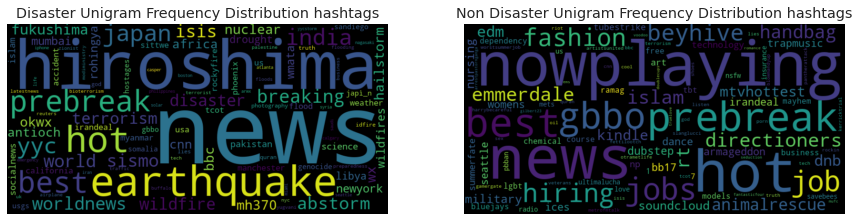

In [55]:
plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,2,1)
#Uigram Frequency distribution for disaster hashtags
#convert disaster hashtags into single string
txt=' '.join(train_df[train_df["target"]==1]["hashtags"])
disaster_unigram_hash=nltk.FreqDist(nltk.word_tokenize(txt))

#visualize unigram frequency distribution for disaster hashtags using wordcloud
disaster_wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(disaster_unigram_hash)
plt.title("Disaster Unigram Frequency Distribution hashtags")
plt.imshow(disaster_wc, interpolation="bilinear")
plt.axis("off")

plt.subplot(1,2,2)
#Uigram Frequency distribution for non disaster hashtags
#convert non disaster hashtags into single string
txt=' '.join(train_df[train_df["target"]==0]["hashtags"])
nondisaster_unigram_hash=nltk.FreqDist(nltk.word_tokenize(txt))

#visualize unigram frequency distribution for non disaster hashtags using wordcloud
nondisaster_wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(nondisaster_unigram_hash)
plt.title("Non Disaster Unigram Frequency Distribution hashtags")
plt.axis("off")
plt.imshow(nondisaster_wc, interpolation="bilinear")
plt.show()

## Neural Network

In [56]:
# Word Embedding
from gensim.models import KeyedVectors
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

# fastText word embeddings

In [57]:
# Downloading fastext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec

--2021-06-20 12:14:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6597238061 (6.1G) [binary/octet-stream]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>]   6.14G  40.2MB/s    in 2m 51s  

2021-06-20 12:17:49 (36.9 MB/s) - ‘wiki.en.vec’ saved [6597238061/6597238061]



In [58]:
train = train_df[['id','text','clean_text_stopword','target']]
train.rename(columns = {'clean_text_stopword':'clean_text'},inplace = True)

In [59]:
train.head(2)

,id,text,clean_text,target
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,1
1,4,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada,1


In [60]:
test = test_df[['id','text','clean_text_stopword']]
test.rename(columns = {'clean_text_stopword':'clean_text'},inplace = True)

In [61]:
test.head(2)

,id,text,clean_text
0,0,Just happened a terrible car crash,happened terrible crash
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...


In [62]:
x_test = test['clean_text']
print('Number of testing sentence: ', x_test.shape)
x_test = np.asarray(x_test)

Number of testing sentence:  (3263,)


In [63]:
x_train = train['clean_text']
y_train = train['target']

In [64]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [65]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (7503,)
Number of training label:  (7503,)


In [66]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [67]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{1: 3198, 0: 4305}


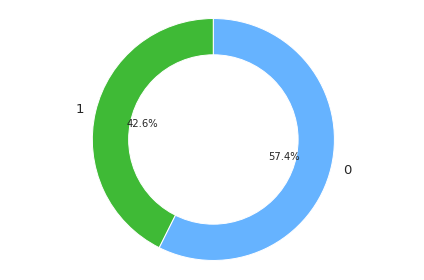

In [68]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

# Prepare FastText Model

In [69]:
EMBEDDING_FILE = 'wiki.en.vec'

def import_with_gensim(file_address):
    # Creating the model
    ft_model = KeyedVectors.load_word2vec_format(file_address)
    # Getting the tokens
    ft_words = []
    for ft_word in ft_model.index_to_key:
        ft_words.append(ft_word)
    return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

In [70]:
# FastText embedding dimensionality
embed_size = 300

In [71]:
# We get the mean and standard deviation of the embedding weights so that we could maintain the
# same statistics for the rest of our own random generated weights.

embedding_list = list()

for w in ft_words:
    embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

# Prepare data for Deep Learning model

## Setting tokenizer up

In [72]:
num_words = 2500

# Create the tokenizer
tokenizer = Tokenizer()

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(x_train)

In [73]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in x_train])

## Embed sentences

In [74]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(x_train)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [75]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)+1

In [76]:
# We are going to set the embedding size to the pre-trained dimension as we are replicating it
nb_words = len(tokenizer.word_index)+1

# the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# With the newly created embedding matrix, we'll fill it up with the words that we have in both
# our own dictionary and loaded pre-trained embedding.
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
    # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    if word in ft_model.index_to_key:
        embedding_vector = ft_model[word]
        # and store inside the embedding matrix that we will train later on.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:   # Unknown words
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

total embedded: 12595 common words
Embedding matrix shape: (12596, 300)


In [77]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(x_test)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

### Train and Validation split

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x_train_padded, y_train, test_size=0.2, random_state=2)

In [79]:
print("Train set has total {0} entries with {1:.2f}% disaster, {2:.2f}% neutral".format(len(X_train),
                                                                             (len(X_train[Y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[Y_train == 1]) / (len(X_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% disaster, {2:.2f}% neutral".format(len(X_val),
                                                                             (len(X_val[Y_val == 0]) / (len(X_val)*1.))*100,
                                                                            (len(X_val[Y_val == 1]) / (len(X_val)*1.))*100))

Train set has total 6002 entries with 57.66% disaster, 42.34% neutral
Validation set has total 1501 entries with 56.23% disaster, 43.77% neutral


## B-LSTM Model

In [80]:
model_blstm_fast = Sequential()
model_blstm_fast.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
model_blstm_fast.add(Bidirectional(LSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm_fast.add(GlobalMaxPool1D())
model_blstm_fast.add(Dropout(0.1))
model_blstm_fast.add(Dense(300, activation="relu"))
model_blstm_fast.add(Dropout(0.1))
model_blstm_fast.add(Dense(1, activation='sigmoid'))

In [81]:
model_blstm_fast.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_blstm_fast.summary()
batch_size_blstm = 32
epochs_blstm = 5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3778800   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 600)         1442400   
_________________________________________________________________
global_max_pooling1d (Global (None, 600)               0         
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [82]:
# Train model
hist_blstm_fast = model_blstm_fast.fit(X_train, Y_train, batch_size=batch_size_blstm, epochs=epochs_blstm,
                             validation_data = (X_val, Y_val))

Epoch 1/5
188/188 [==============================] - 28s 132ms/step - loss: 0.6644 - accuracy: 0.5903 - val_loss: 0.6171 - val_accuracy: 0.6622
Epoch 2/5
188/188 [==============================] - 23s 123ms/step - loss: 0.5324 - accuracy: 0.7340 - val_loss: 0.5106 - val_accuracy: 0.7722
Epoch 3/5
188/188 [==============================] - 23s 122ms/step - loss: 0.4095 - accuracy: 0.8209 - val_loss: 0.4828 - val_accuracy: 0.7861
Epoch 4/5
188/188 [==============================] - 23s 123ms/step - loss: 0.2922 - accuracy: 0.8882 - val_loss: 0.5070 - val_accuracy: 0.7875
Epoch 5/5
188/188 [==============================] - 23s 123ms/step - loss: 0.1989 - accuracy: 0.9328 - val_loss: 0.5526 - val_accuracy: 0.7801


In [83]:
# Evaluate model
loss_blstm_fast, acc_blstm_fast = model_blstm_fast.evaluate(X_val, Y_val, verbose=0)
print('Test Accuracy: %f' % (acc_blstm_fast*100))

Test Accuracy: 78.014654


In [84]:
# Get prediction label
y_pred_val_blstm_fast = model_blstm_fast.predict_classes(X_val)

In [85]:
# Get prediction label
y_pred_blstm_fast = model_blstm_fast.predict_classes(x_test_padded)

## CNN Model


In [86]:
model_cnn_fast = Sequential()
model_cnn_fast.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
model_cnn_fast.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn_fast.add(MaxPooling1D(pool_size=2))
model_cnn_fast.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn_fast.add(MaxPooling1D(pool_size=2))
model_cnn_fast.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn_fast.add(GlobalMaxPooling1D())
model_cnn_fast.add(Dropout(0.1))
model_cnn_fast.add(Dense(500, activation="sigmoid"))
model_cnn_fast.add(Dense(1, activation='sigmoid'))

In [87]:
model_cnn_fast.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn_fast.summary()
batch_size_cnn = 64
epochs_cnn = 10

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3778800   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          76864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          65600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)               

In [88]:
# Train model
hist_cnn_fast = model_cnn_fast.fit(X_train, Y_train, batch_size=batch_size_cnn, epochs=epochs_cnn,
                        validation_data = (X_val, Y_val))

Epoch 1/10
94/94 [==============================] - 3s 24ms/step - loss: 0.6777 - accuracy: 0.5702 - val_loss: 0.6695 - val_accuracy: 0.6096
Epoch 2/10
94/94 [==============================] - 2s 21ms/step - loss: 0.5715 - accuracy: 0.7020 - val_loss: 0.5361 - val_accuracy: 0.7315
Epoch 3/10
94/94 [==============================] - 2s 21ms/step - loss: 0.4305 - accuracy: 0.8149 - val_loss: 0.5329 - val_accuracy: 0.7582
Epoch 4/10
94/94 [==============================] - 2s 21ms/step - loss: 0.3008 - accuracy: 0.8887 - val_loss: 0.6423 - val_accuracy: 0.7335
Epoch 5/10
94/94 [==============================] - 2s 20ms/step - loss: 0.1910 - accuracy: 0.9387 - val_loss: 0.6946 - val_accuracy: 0.7495
Epoch 6/10
94/94 [==============================] - 2s 22ms/step - loss: 0.1540 - accuracy: 0.9525 - val_loss: 0.7726 - val_accuracy: 0.7268
Epoch 7/10
94/94 [==============================] - 2s 21ms/step - loss: 0.1260 - accuracy: 0.9634 - val_loss: 0.8779 - val_accuracy: 0.7275
Epoch 8/10
94

In [89]:
# Evaluate model
loss_cnn_fast, acc_cnn_fast = model_cnn_fast.evaluate(X_val, Y_val, verbose=0)
print('Test Accuracy: %f' % (acc_cnn_fast*100))

Test Accuracy: 73.550963


In [90]:
y_pred_val_cnn_fast = model_cnn_fast.predict_classes(X_val)

In [91]:
# Get prediction label
y_pred_cnn_fast = model_cnn_fast.predict_classes(x_test_padded)

## Model Evaluation and Confusion Matrix

In [92]:
def model_evaluation(model):
    t_loss = model.history['loss']
    t_acc  = model.history['accuracy']
    v_loss = model.history['val_loss']
    v_acc  = model.history['val_accuracy']
    x_axis = len(t_loss)

    fig,(ax1) = plt.subplots(1,1,figsize=(12,8))
    ax1.plot(t_acc,color = 'blue',label = 'Train')
    ax1.plot(v_acc,color = 'orange',label = 'Val')
    ax1.set_title('Accuracy Plot')
    ax1.set_xlabel("#Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    
    plt.show()


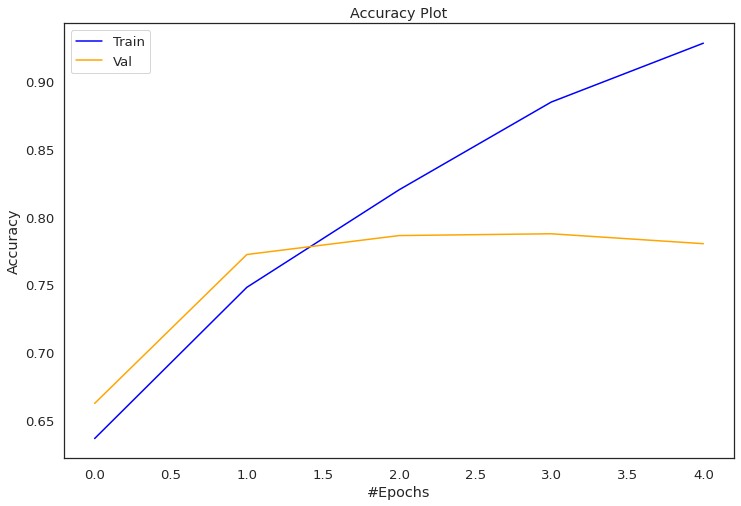

In [93]:
model_evaluation(hist_blstm_fast)

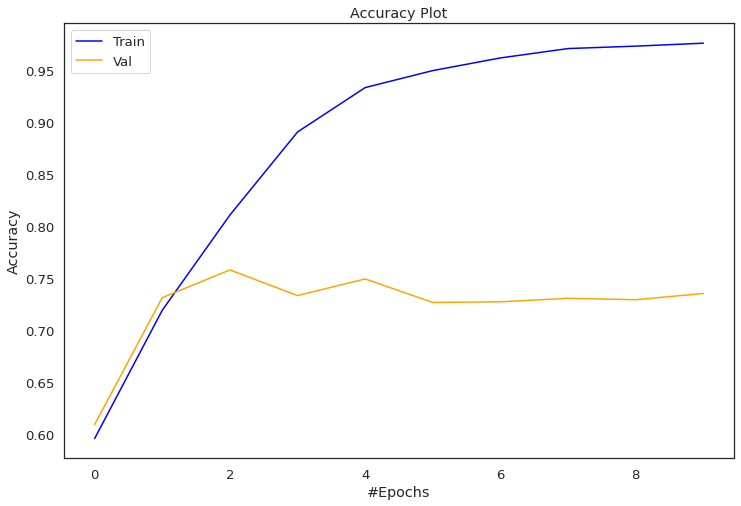

In [94]:
model_evaluation(hist_cnn_fast)

In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[686 158]
 [172 485]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.81 0.19]
 [0.26 0.74]]
AxesImage(54,36;334.8x217.44)


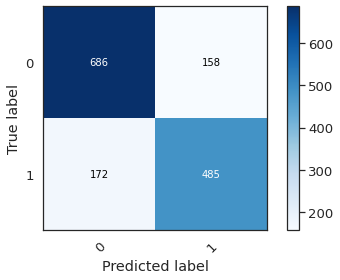

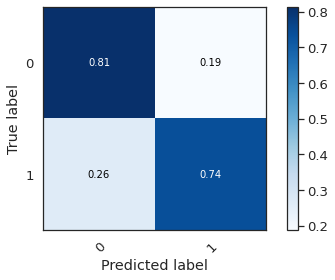

In [96]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_blstm_fast, classes=class_names)
# plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_blstm_fast, classes=class_names, normalize=True)
# Decomment following line if you want to save the figure
# plt.savefig('cm-blstm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[699 145]
 [252 405]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.83 0.17]
 [0.38 0.62]]
AxesImage(54,36;334.8x217.44)


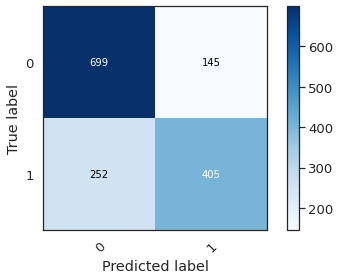

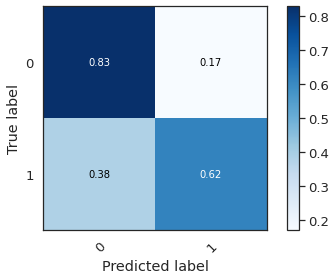

In [97]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_cnn_fast, classes=class_names)
# plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_cnn_fast, classes=class_names, normalize=True)
# plt.savefig('cm-cnn-normalized.png')
plt.show()

In [98]:
print("(Weighted) F1 score of FasttextEmb B-LSTM model:")
f1_score(Y_val, y_pred_val_blstm_fast, average='weighted')

(Weighted) F1 score of FasttextEmb B-LSTM model:


0.7798669578381654

In [99]:
print("(Weighted) F1 score of FasttextEmb B-LSTM model:")
f1_score(Y_val, y_pred_val_cnn_fast, average='weighted')

(Weighted) F1 score of FasttextEmb B-LSTM model:


0.731669324437562

## Keras embedding

### BLSTM

In [100]:
model_blstm_keras = Sequential()
model_blstm_keras.add(Embedding(vocab_size, 300, input_length=max_length))
model_blstm_keras.add(Bidirectional(LSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm_keras.add(GlobalMaxPool1D())
model_blstm_keras.add(Dropout(0.3))
model_blstm_keras.add(Dense(300, activation="relu"))
model_blstm_keras.add(Dropout(0.3))
model_blstm_keras.add(Dense(300, activation="relu"))
model_blstm_keras.add(Dropout(0.3))
model_blstm_keras.add(Dense(1, activation='sigmoid'))

In [101]:
model_blstm_keras.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_blstm_keras.summary()
batch_size_blstm = 32
epochs_blstm = 5

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 300)           3778800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 600)           1442400   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 600)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)              

In [102]:
# Train model
hist_blstm_keras = model_blstm_keras.fit(X_train, Y_train, batch_size=batch_size_blstm, epochs=epochs_blstm,
                             validation_data = (X_val, Y_val))

Epoch 1/5
188/188 [==============================] - 39s 193ms/step - loss: 0.6203 - accuracy: 0.6506 - val_loss: 0.4486 - val_accuracy: 0.8141
Epoch 2/5
188/188 [==============================] - 35s 188ms/step - loss: 0.2978 - accuracy: 0.8898 - val_loss: 0.4660 - val_accuracy: 0.7975
Epoch 3/5
188/188 [==============================] - 36s 190ms/step - loss: 0.1606 - accuracy: 0.9440 - val_loss: 0.5630 - val_accuracy: 0.7815
Epoch 4/5
188/188 [==============================] - 35s 188ms/step - loss: 0.0927 - accuracy: 0.9685 - val_loss: 0.8131 - val_accuracy: 0.7742
Epoch 5/5
188/188 [==============================] - 35s 187ms/step - loss: 0.0705 - accuracy: 0.9710 - val_loss: 1.2121 - val_accuracy: 0.7755


In [103]:
# Evaluate model
loss_blstm_keras, acc_blstm_keras = model_blstm_keras.evaluate(X_val, Y_val, verbose=0)
print('Test Accuracy: %f' % (acc_blstm_keras*100))

Test Accuracy: 77.548301


In [104]:
# Get prediction label
y_pred_val_blstm_keras = model_blstm_keras.predict_classes(X_val)

In [105]:
# Get prediction label
y_pred_blstm_keras = model_blstm_keras.predict_classes(x_test_padded)

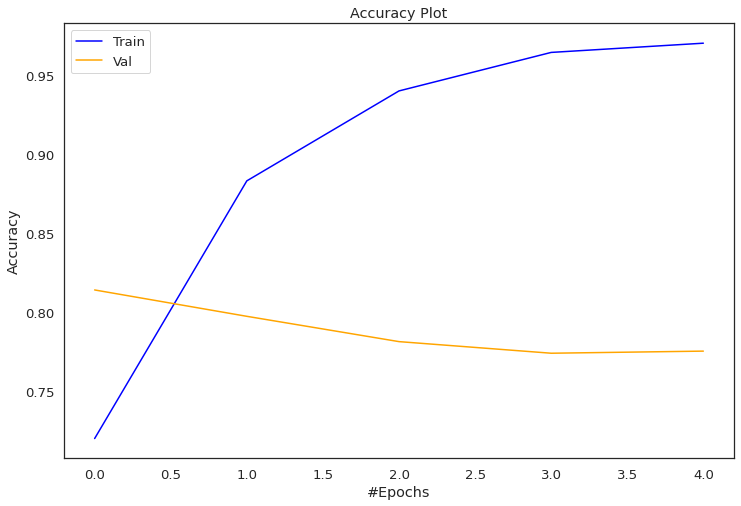

In [106]:
model_evaluation(hist_blstm_keras)

# CNN Model

In [107]:
model_cnn_keras = Sequential()
model_cnn_keras.add(Embedding(vocab_size, 300, input_length=max_length))
model_cnn_keras.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn_keras.add(MaxPooling1D(pool_size=2))
model_cnn_keras.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn_keras.add(MaxPooling1D(pool_size=2))
model_cnn_keras.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn_keras.add(GlobalMaxPooling1D())
model_cnn_keras.add(Dropout(0.1))
model_cnn_keras.add(Dense(500, activation="sigmoid"))
model_cnn_keras.add(Dense(1, activation='sigmoid'))

In [108]:

model_cnn_keras.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn_keras.summary()
batch_size_cnn = 64
epochs_cnn = 10

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 300)           3778800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 64)            76864     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 64)             65600     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)               

In [109]:
# Train model
hist_cnn_keras = model_cnn_keras.fit(X_train, Y_train, batch_size=batch_size_cnn, epochs=epochs_cnn,
                        validation_data = (X_val, Y_val))

Epoch 1/10
94/94 [==============================] - 6s 52ms/step - loss: 0.6566 - accuracy: 0.5949 - val_loss: 0.4534 - val_accuracy: 0.8028
Epoch 2/10
94/94 [==============================] - 5s 51ms/step - loss: 0.3307 - accuracy: 0.8680 - val_loss: 0.4979 - val_accuracy: 0.8101
Epoch 3/10
94/94 [==============================] - 5s 54ms/step - loss: 0.1424 - accuracy: 0.9541 - val_loss: 0.6221 - val_accuracy: 0.7841
Epoch 4/10
94/94 [==============================] - 5s 54ms/step - loss: 0.0811 - accuracy: 0.9713 - val_loss: 0.7707 - val_accuracy: 0.7868
Epoch 5/10
94/94 [==============================] - 5s 51ms/step - loss: 0.0487 - accuracy: 0.9786 - val_loss: 0.8698 - val_accuracy: 0.7828
Epoch 6/10
94/94 [==============================] - 5s 55ms/step - loss: 0.0355 - accuracy: 0.9840 - val_loss: 1.0061 - val_accuracy: 0.7855
Epoch 7/10
94/94 [==============================] - 5s 52ms/step - loss: 0.0327 - accuracy: 0.9857 - val_loss: 1.1730 - val_accuracy: 0.7808
Epoch 8/10
94

In [110]:
# Evaluate model
loss_cnn_keras, acc_cnn_keras = model_cnn_keras.evaluate(X_val, Y_val, verbose=0)
print('Test Accuracy: %f' % (acc_cnn_keras*100))

Test Accuracy: 77.215189


In [111]:
y_pred_val_cnn_keras= model_cnn_keras.predict_classes(X_val)

In [112]:
# Get prediction label
y_pred_cnn_keras = model_cnn_keras.predict_classes(x_test_padded)

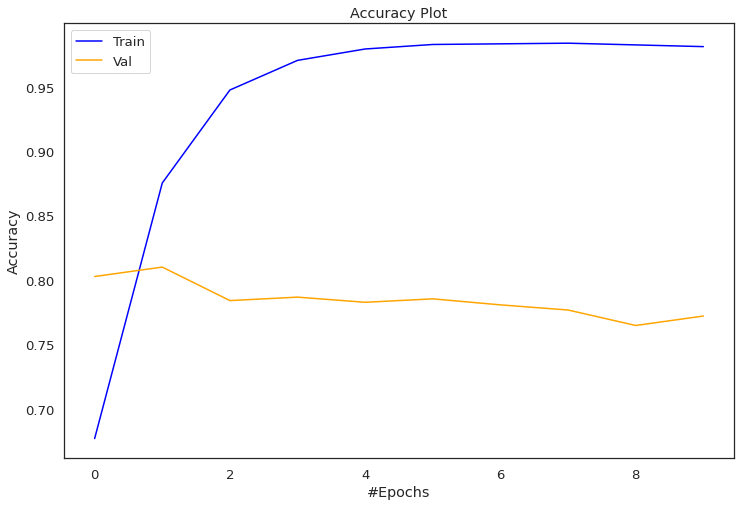

In [113]:
model_evaluation(hist_cnn_keras)

## Confusion Matrix

Confusion matrix, without normalization
[[701 143]
 [194 463]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.83 0.17]
 [0.3  0.7 ]]
AxesImage(54,36;334.8x217.44)


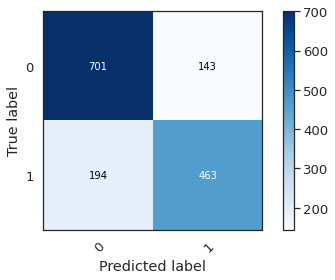

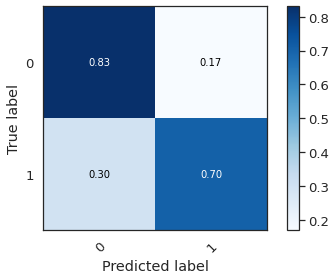

In [114]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_blstm_keras, classes=class_names)
# plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_blstm_keras, classes=class_names, normalize=True)
# Decomment following line if you want to save the figure
# plt.savefig('cm-blstm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[697 147]
 [195 462]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.83 0.17]
 [0.3  0.7 ]]
AxesImage(54,36;334.8x217.44)


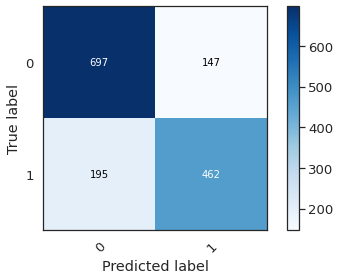

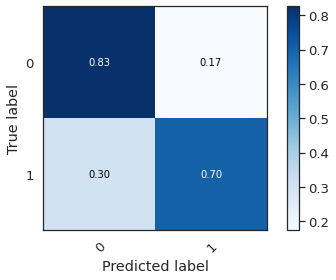

In [115]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_cnn_keras, classes=class_names)
# plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_val_cnn_keras, classes=class_names, normalize=True)
# plt.savefig('cm-cnn-normalized.png')
plt.show()

In [116]:
print("(Weighted) F1 score of KerasEmb B-LSTM model:")
f1_score(Y_val, y_pred_val_blstm_keras, average='weighted')

(Weighted) F1 score of KerasEmb B-LSTM model:


0.7742422352549857

In [117]:
print("(Weighted) F1 score of KerasEmb CNN model:")
f1_score(Y_val, y_pred_val_cnn_keras, average='weighted')

(Weighted) F1 score of KerasEmb CNN model:


0.7709824771997359

# Machine Learning Algorithms

In [118]:
# sklearn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline

# Measuring metrics
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize

In [119]:
# When building the vocabulary ignore terms that have a document frequency strictly lower than
# the given threshold. This value is also called cut-off in the literature.
min_df = 1

# Tokenize function used in Vectorizer
def tokenize(text):
    return word_tokenize(text)

### Naive Bayes

In [120]:
train.head(2)

,id,text,clean_text,target
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,1
1,4,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada,1


In [121]:
test.head(2)

,id,text,clean_text
0,0,Just happened a terrible car crash,happened terrible crash
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...


In [122]:
x_test = test['clean_text']
print('Number of testing sentence: ', x_test.shape)
x_test = np.asarray(x_test)

Number of testing sentence:  (3263,)


In [123]:
x_train = np.asarray(train['clean_text'])
y_train = np.asarray(train['target'])
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (7503,)
Number of training label:  (7503,)


In [124]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2)

In [125]:
# Naive Bayes Model
naive_bayes = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                              analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                     ('tfidf', TfidfTransformer(sublinear_tf=True)),
                     ('clf', MultinomialNB())])
naive_bayes = naive_bayes.fit(X_train, Y_train)
naive_score = naive_bayes.score(X_val, Y_val)
print('Naive Bayes Model: ', naive_score)
predict_val_nb = naive_bayes.predict(X_val)

Naive Bayes Model:  0.8141239173884077


In [126]:
predict_nb = naive_bayes.predict(x_test)

### Linear Support Vector Machine Model

In [127]:
# Linear Support Vector Machine Model
svm = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                         analyzer='word', ngram_range=(1, 2),
                                                         min_df=min_df, lowercase=False)),
                                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                                ('clf-svm', LinearSVC(loss='hinge', penalty='l2',
                                                      max_iter=5))])

svm = svm.fit(X_train, Y_train)
linear_svc_score = svm.score(X_val, Y_val)
print('Linear SVC Model: ', linear_svc_score)
predict_val_svm = svm.predict(X_val)

Linear SVC Model:  0.8181212524983345


In [128]:
predict_svm = svm.predict(x_test)

### Stochastic Gradient Descent Model

In [129]:
# SGD (Stochastic Gradient Descent) Model
sgd = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                  analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                         ('tfidf', TfidfTransformer(sublinear_tf=True)),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, max_iter=5))])
sgd = sgd.fit(X_train, Y_train)
sgd_score = sgd.score(X_val, Y_val)
print('SGD Model: ', sgd_score)
predict_val_sgd = sgd.predict(X_val)

SGD Model:  0.6988674217188541


In [130]:
predict_sgd = sgd.predict(x_test)

# Confusion Matrix

In [131]:
Y_val = Y_val.astype(int)
predict_val_nb = predict_val_nb.astype(int)
predict_val_svm = predict_val_svm.astype(int)
predict_val_sgd = predict_val_sgd.astype(int)

Confusion matrix, without normalization
[[782  62]
 [217 440]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.93 0.07]
 [0.33 0.67]]
AxesImage(54,36;334.8x217.44)


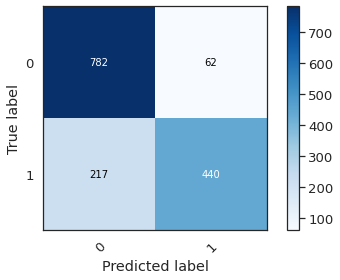

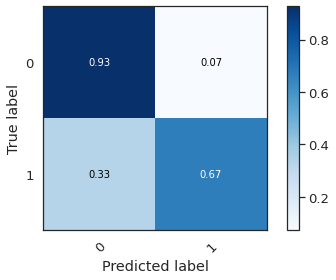

In [132]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, predict_val_nb, classes=class_names)
# plt.savefig('cm-nb.png')
# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, predict_val_nb, classes=class_names, normalize=True)
# plt.savefig('cm-nb-normalized.png')
plt.show()

Confusion matrix, without normalization
[[726 118]
 [155 502]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.86 0.14]
 [0.24 0.76]]
AxesImage(54,36;334.8x217.44)


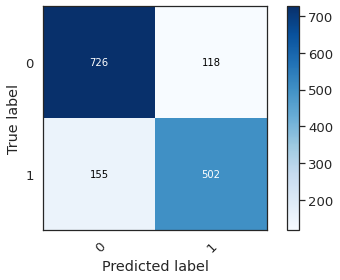

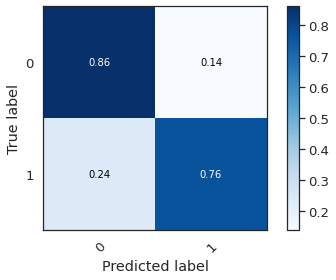

In [133]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, predict_val_svm, classes=class_names)
# plt.savefig('cm-svm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, predict_val_svm, classes=class_names, normalize=True)
# plt.savefig('cm-svm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[839   5]
 [447 210]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.99 0.01]
 [0.68 0.32]]
AxesImage(54,36;334.8x217.44)


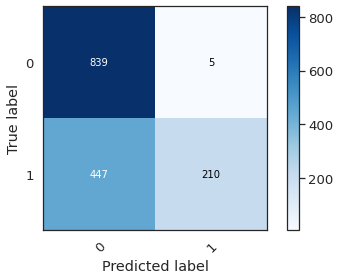

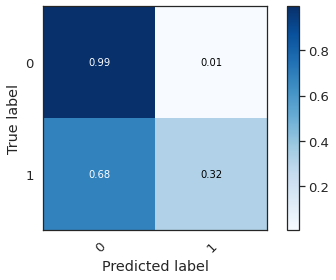

In [134]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, predict_val_sgd, classes=class_names)
# plt.savefig('cm-sgd.png')
# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, predict_val_sgd, classes=class_names, normalize=True)
# plt.savefig('cm-sgd-normalized.png')
plt.show()

# F1 Score

In [135]:
print("F1 score of NB model:")
f1_score(Y_val, predict_val_nb, average='weighted')

F1 score of NB model:


0.809511033276737

In [136]:
print("F1 score of SVM model:")
f1_score(Y_val, predict_val_svm, average='weighted')

F1 score of SVM model:


0.8174369443670513

In [137]:
print("F1 score of SGD model:")
f1_score(Y_val, predict_val_sgd, average='weighted')

F1 score of SGD model:


0.6537925427785476

# Try other models

In [138]:
train.head(2)

,id,text,clean_text,target
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,1
1,4,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada,1


In [139]:
test.head(2)

,id,text,clean_text
0,0,Just happened a terrible car crash,happened terrible crash
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...


In [140]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import re
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score #Compute Area Under the Curve (AUC) from prediction scores

import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

In [141]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

X = train['clean_text'].to_numpy()
y = train['target'].to_numpy()

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train = X.loc[train_index]
    X_train, X_test = X[train_index], X[test_index]

    y_train, y_test = y[train_index], y[test_index]

TRAIN: [5177  221 1508 ... 6520  925 6960] TEST: [5784 7062 3843 ... 3921  383 6272]


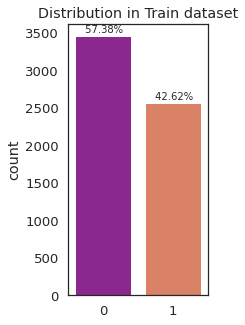

In [142]:
plt.figure(figsize=(2.5,5))
plt.title("Distribution in Train dataset")
p1 = sns.countplot(y_train, palette = 'plasma')

for p in p1.patches:
        p1.annotate('{:6.2f}%'.format(p.get_height()/len(y_train)*100), (p.get_x()+0.1, p.get_height()+50))
        
plt.show()

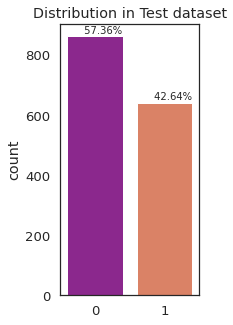

In [143]:
plt.figure(figsize=(2.5,5))
plt.title("Distribution in Test dataset")
p1 = sns.countplot(y_test, palette = 'plasma')

for p in p1.patches:
        p1.annotate('{:6.2f}%'.format(p.get_height()/len(y_test)*100), (p.get_x()+0.2, p.get_height()+12))
        
plt.show()

In [144]:
tweets_pipeline = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer())])

X_train_tranformed = tweets_pipeline.fit_transform(X_train)
X_test_tranformed = tweets_pipeline.transform(X_test)

In [145]:
classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(class_weight='balanced'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    'MNB': MultinomialNB(),
    'Perceptron': Perceptron(class_weight='balanced'),
    'xgboost': XGBClassifier(n_estimators=300),
    'catboost': CatBoostClassifier(verbose=0)
        
}

In [146]:
no_classifiers = len(classifiers.keys())

from time import process_time 


def batch_classify(X_train_tranformed, y_train, X_test_tranformed, y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['Classifier', 'Area Under Curve', 'Training time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = process_time()  
        classifier.fit(X_train_tranformed, y_train)
        t_stop = process_time() 
        t_elapsed = t_stop - t_start
        y_predicted = classifier.predict(X_test_tranformed)
        
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Area Under Curve'] = roc_auc_score(y_test, y_predicted)
        df_results.loc[count,'Training time'] = t_elapsed
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_elapsed))
        count+=1

    return df_results

In [147]:
df_results = batch_classify(X_train_tranformed, y_train,X_test_tranformed, y_test)
print(df_results.sort_values(by='Area Under Curve', ascending=False))

trained Logistic Regression in 0.65 s
trained Decision Tree in 2.19 s
trained k-Nearest Neighbors in 0.00 s
trained Linear SVM in 3.52 s
trained Gradient Boosting Classifier in 1.68 s
trained Random Forest in 8.38 s
trained RidgeClassifier in 0.09 s
trained AdaBoost in 1.33 s
trained MNB in 0.00 s
trained Perceptron in 0.03 s
[12:48:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
trained xgboost in 12.58 s
trained catboost in 156.75 s
                      Classifier  Area Under Curve  Training time
8                            MNB          0.801600       0.003396
3                     Linear SVM          0.798516       3.522411
0            Logistic Regression          0.789551       0.650563
5                  Random Forest          0.773780       8.382227
11                      catboost  